# Limited Input Approach
In the case where input for both training and testing is just limited to X, Y, Z coordinates, the approach to predicting the trajectory of a shuttlecock is different and less accurate. 

## Importing Libraries and Dependencies

In [52]:
# %pip install pandas
# %pip install matplotlib
# %pip install plotly
# %pip install scikit-learn
# %pip install numpy

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import math

## Stage: Preprocessing
To first mockup data with just X, Y, Z values. Then to perform relevant data reduction and feature engineering to improve data quality

In [54]:
# # read csv data from badmintondata.csv
# limited_serving_data = pd.read_csv('badmintondata.csv')

# # just rename x metrics to avoid unnecessary errors
# limited_serving_data = limited_serving_data.rename(columns={'SHUTTLECOCK POSITIION IN AIR(X ) metres': 'SHUTTLECOCK POSITIION IN AIR(X) metres'})

# # limiting service data to just x, y, z coordinates
# limited_serving_data = limited_serving_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Z) metres']]
# limited_serving_data

In [55]:
# # read csv data from badmintondata.csv
# limited_rallying_data = pd.read_csv('badmintondata2.csv')

# # just rename x metrics to avoid unnecessary errors
# limited_rallying_data = limited_rallying_data.rename(columns={'SHUTTLECOCK POSITIION IN AIR(X ) metres': 'SHUTTLECOCK POSITIION IN AIR(X) metres'})

# # limiting service data to just x, y, z coordinates
# limited_rallying_data = limited_rallying_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
#                                             'SHUTTLECOCK POSITIION IN AIR(Z) metres']]
# limited_rallying_data

Assigning data to observation groups and labelling their sequences with observation numbers

In [56]:
# # Initialize variables
# observation_group_num = 0
# observation_num = 0
# is_group = False

# # assign observation groups and their respective observation numbers to each row
# for index, row in limited_serving_data.iterrows():
#     if row['SHUTTLECOCK POSITIION IN AIR(X) metres'] == 0:
#         if is_group:
#             is_group = False
#         limited_serving_data.drop(index, inplace=True)
#     # if row is not empty
#     else:
#         # if inside an observation group just increment observation number
#         if is_group:
#             observation_num+=1
#         # if just entering a new observation group
#         else:
#             is_group = True
#             # increase observation group number by 1
#             observation_group_num+=1
#             # resets observation sequence number to 1
#             observation_num = 1
#         # assign observation group and observation number
#         limited_serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#         limited_serving_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# # Set 'OBSERVATION GROUP NUMBER' as INT
# limited_serving_data['OBSERVATION GROUP NUMBER'] = limited_serving_data['OBSERVATION GROUP NUMBER'].astype(int)
# limited_serving_data.to_csv('cleaned_limited_serving_data.csv')

In [57]:
# # Initialize variables
# observation_group_num = 364 # last observation group number index from dataset 1
# observation_num = 0
# is_group = False

# # assign observation groups and their respective observation numbers to each row
# for index, row in limited_rallying_data.iterrows():
#     if row['SHUTTLECOCK POSITIION IN AIR(X) metres'] == 0:
#         if is_group:
#             is_group = False
#         limited_rallying_data.drop(index, inplace=True)
#     # if row is not empty
#     else:
#         # if inside an observation group just increment observation number
#         if is_group:
#             observation_num+=1
#         # if just entering a new observation group
#         else:
#             is_group = True
#             # increase observation group number by 1
#             observation_group_num+=1
#             # resets observation sequence number to 1
#             observation_num = 1
#         # assign observation group and observation number
#         limited_rallying_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#         limited_rallying_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# # Set 'OBSERVATION GROUP NUMBER' as INT
# limited_rallying_data['OBSERVATION GROUP NUMBER'] = limited_rallying_data['OBSERVATION GROUP NUMBER'].astype(int)

Determining the initial starting position of each shuttlecock based on the rounded down value of the first observation

In [58]:
limited_serving_data = pd.read_csv('cleaned_limited_serving_data.csv')
limited_serving_data = limited_serving_data.drop(columns=('Unnamed: 0'))
# Add Initial Points of Human Position based on the rounded down version of the first point
# Reset the index before applying groupby
def calculate_human_position(group):
    rounded_value_x = math.floor(group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(X) metres'])
    rounded_value_y = round(group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Y) metres'])
    rounded_value_z = rounded_value = min(1.6, 2.6, key=lambda x: abs(x - group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Z) metres']))
    group['HUMAN PLAYER POSITION (X) metres'] = rounded_value_x
    group['HUMAN PLAYER POSITION (Y) metres'] = rounded_value_y
    group['HUMAN PLAYER POSITION (Z) metres'] = rounded_value_z
    return group

# Apply the function to each group using groupby and apply
limited_serving_data = limited_serving_data.groupby('OBSERVATION GROUP NUMBER').apply(calculate_human_position)
limited_serving_data = limited_serving_data.reset_index(drop=True)

In [59]:
limited_rallying_data = pd.read_csv('cleaned_limited_rallying_data.csv')
# limited_rallying_data = limited_serving_data.drop(columns=('Unnamed: 0'))
# Add Initial Points of Human Position based on the rounded down version of the first point
# Reset the index before applying groupby
# def calculate_human_position_v2(group):
#     rounded_value_x = math.floor(group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(X) metres'])
#     rounded_value_y = round(group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Y) metres'])
#     group['HUMAN PLAYER POSITION (X) metres'] = rounded_value_x
#     group['HUMAN PLAYER POSITION (Y) metres'] = rounded_value_y
#     group['HUMAN PLAYER POSITION (Z) metres'] = 2.6
#     return group

# Apply the function to each group using groupby and apply
limited_rallying_data = limited_rallying_data.groupby('OBSERVATION GROUP NUMBER').apply(calculate_human_position)
limited_rallying_data = limited_rallying_data.reset_index(drop=True)

Creating Velocity, Slant Angles and Firing Angles of each shuttlecock using mathematical equation with X,Y,Z manipulation

In [60]:
def generate_features(group):
    # calculate X,Y,Z distances from initial human points
    X_displacement = group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(X) metres'] - group.iloc[0]['HUMAN PLAYER POSITION (X) metres']
    Y_displacement = group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Y) metres'] - group.iloc[0]['HUMAN PLAYER POSITION (Y) metres'] 
    Z_displacement = group.iloc[0]['SHUTTLECOCK POSITIION IN AIR(Z) metres'] - group.iloc[0]['HUMAN PLAYER POSITION (Z) metres']

    # calculate initial firing angle
    firing_angle_radians = math.atan(X_displacement / Z_displacement)
    firing_angle_degrees = math.degrees(firing_angle_radians)
    # round to nearest 10 for firing angle
    group['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'] = round(firing_angle_degrees / 10) * 10

    # calculate initial slant angle
    slant_angle_radians = math.atan(Y_displacement / X_displacement)
    slant_angle_degrees = math.degrees(slant_angle_radians)
    group['INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = round(slant_angle_degrees)

    # Calculate the initial velocity (v₀)
    time_elapsed = 0.1
    displacement = math.sqrt(X_displacement**2 + Y_displacement**2 + Z_displacement**2)
    initial_velocity = round(displacement/time_elapsed)
    # round to nearest 10 for velocity
    group['INITITAL VELOCITY OF SHUTTELCOCK(m/s)'] = initial_velocity
    return group

# generate features for serving data
limited_serving_data = limited_serving_data.groupby('OBSERVATION GROUP NUMBER').apply(generate_features)
limited_serving_data = limited_serving_data.reset_index(drop=True)
limited_serving_data.to_csv('cleaned_limited_serving_data_v2.csv')

# generate features for rallying data
limited_rallying_data = limited_rallying_data.groupby('OBSERVATION GROUP NUMBER').apply(generate_features)
limited_rallying_data = limited_rallying_data.reset_index(drop=True)
limited_rallying_data.to_csv('cleaned_limited_rallying_data_v2.csv')

Combine the two datasets into a single dataset

In [61]:
limited_serving_data = pd.read_csv('cleaned_limited_serving_data_v2.csv')
limited_serving_data = limited_serving_data.drop(columns=['Unnamed: 0'])

limited_rallying_data = pd.read_csv('cleaned_limited_rallying_data_v2.csv')
limited_rallying_data = limited_rallying_data.drop(columns=['Unnamed: 0'])

# combining the serving and rally dataframes
limited_badminton_data = pd.concat([limited_serving_data, limited_rallying_data], ignore_index=True)
limited_badminton_data = limited_badminton_data.drop(columns=['Unnamed: 0.1'])
limited_badminton_data.to_csv('cleaned_limited_badminton_data.csv')

## Feature Significance
Selecting features to test significance using PCA and normalizing them. 

In [62]:
# removal of labels and dependent features
X_limited_features = limited_badminton_data.drop(columns=['OBSERVATION GROUP NUMBER',
                                            'SHUTTLECOCK POSITIION IN AIR(X) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Z) metres'])
X_limited_features


# Standardize the data
scaler = StandardScaler()
X_features_norm = scaler.fit_transform(X_limited_features)

Feature INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE): Significance = 0.1865320813023315
Feature HUMAN PLAYER POSITION (Z) metres: Significance = 0.17677218072800077
Feature OBSERVATION NUMBER: Significance = 0.15130267848959464
Feature INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE): Significance = 0.1506764619077837
Feature INITITAL VELOCITY OF SHUTTELCOCK(m/s): Significance = 0.13679930347016042
Feature HUMAN PLAYER POSITION (Y) metres: Significance = 0.11239037013040225
Feature HUMAN PLAYER POSITION (X) metres: Significance = 0.08552692397172691


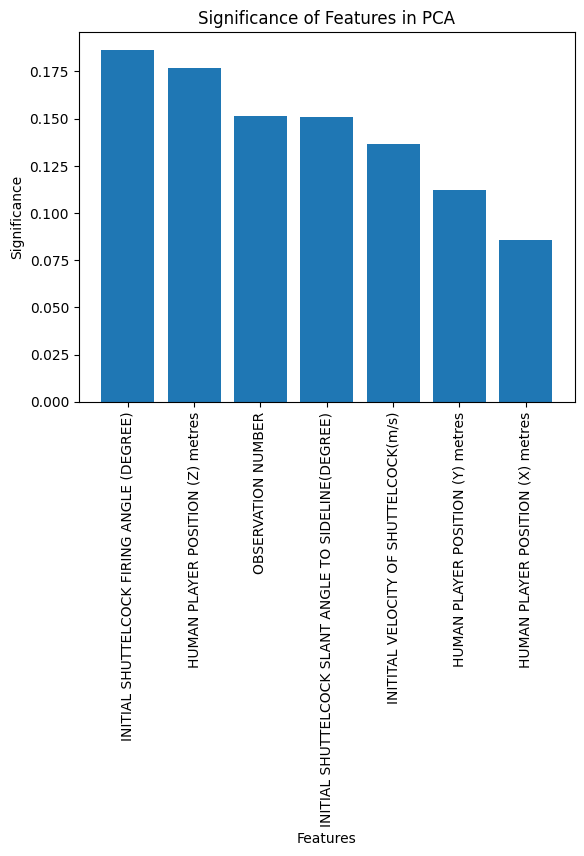

In [63]:
# instantiate PCA object, fit model
pca = PCA()
pca.fit(X_features_norm)

# loadings refer to the coefficients or weights that determine the contribution of each feature to the principal components
# Get the absolute loadings for each feature in each principal component
absolute_loadings = np.abs(pca.components_)
# Calculate the total sum of absolute loadings for each feature across all principal components
total_loadings = np.sum(absolute_loadings, axis=0)

# Calculate the relative contribution of each feature to the total loadings
relative_contribution = total_loadings / np.sum(total_loadings)

# Sort the features based on their relative contribution
sorted_features = np.argsort(relative_contribution)[::-1]
feature_names = X_limited_features.columns
# Print the significance of each feature
for feature_idx in sorted_features:
    print(f"Feature {feature_names[feature_idx]}: Significance = {relative_contribution[feature_idx]}")

# Plot the significance of each feature
plt.bar(range(len(sorted_features)), relative_contribution[sorted_features])
plt.xlabel('Features')
plt.ylabel('Significance')
plt.title('Significance of Features in PCA')
plt.xticks(range(len(sorted_features)), feature_names[sorted_features], rotation=90)
# plt.xticks(range(len(sorted_features)), sorted_features)
plt.show()

## Stage: Data Mining
### Preparing data for Decision Tree Classifier
To determine observation steps needed for a trajectory, only these X features are needed. No normalization is needed
- 'HUMAN PLAYER POSITION (X) metres'
- 'HUMAN PLAYER POSITION (Y) metres'
- 'HUMAN PLAYER POSITION (Z) metres'
- 'INITITAL VELOCITY OF SHUTTELCOCK(m/s)'
- 'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'
- 'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'

In [64]:
# loading data
temp_data = pd.read_csv('cleaned_limited_badminton_data.csv')
temp_data = temp_data.drop(columns=['Unnamed: 0'])

# Drop duplicates based on 'Observation Group Number', keeping only the last record
data_DT = temp_data.copy()
data_DT = data_DT.drop_duplicates(subset='OBSERVATION GROUP NUMBER', keep='last')

# Define X and Y Features for Decision Tree
X_features_DT = data_DT[['HUMAN PLAYER POSITION (X) metres', 
                            'HUMAN PLAYER POSITION (Y) metres',
                            'HUMAN PLAYER POSITION (Z) metres', 
                            'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                            'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                            'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]

Y_feature_DT = data_DT['OBSERVATION NUMBER']

# Split the data into train/test, X/Y for Decision Tree Classifier
X_train_DT, X_test_DT, Y_train_DT, Y_test_DT = train_test_split(X_features_DT, Y_feature_DT, test_size=0.2, random_state=42)

### Finding Optimal Decision Tree Model
To predict total observation time based on the independent feature supplied. Predicts a set of observation take

In [65]:
from sklearn.tree import DecisionTreeClassifier
maxdepths = [2,3,4,5,6,7,8,9,10,15]  # 10 different depths

# containers to store train/test accuracy rates
trainAcc_DT = np.zeros(len(maxdepths))
testAcc_DT = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    # training decision tree with depth lengths
    temp_model_DT = DecisionTreeClassifier(max_depth=depth)
    temp_model_DT = temp_model_DT.fit(X_train_DT, Y_train_DT)
    # generate predictions using the model trained, for the training data (X) and test data (X)
    Y_predTrain = temp_model_DT.predict(X_train_DT)
    Y_predTest = temp_model_DT.predict(X_test_DT)
    # compare the predicted values and compare against original values for accuracy
    trainAcc_DT[index] = accuracy_score(Y_train_DT, Y_predTrain)
    testAcc_DT[index] = accuracy_score(Y_test_DT, Y_predTest)
    index += 1

Text(0, 0.5, 'Accuracy')

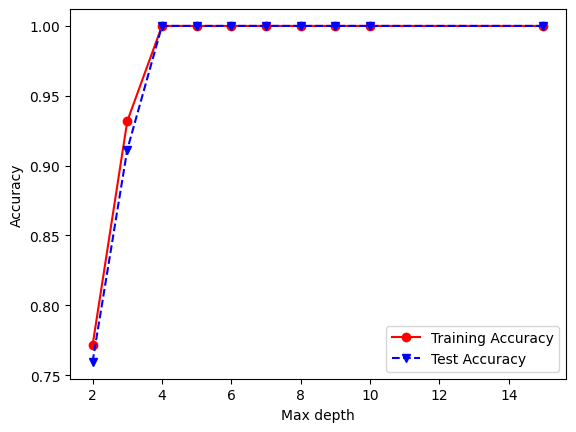

In [66]:
plt.plot(maxdepths,trainAcc_DT,'ro-',maxdepths,testAcc_DT,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

### Train Decision Tree Model "Model_DecisionTree"
Using the optimal elbow depth found in the previous segment which is 4

In [67]:
model_decisionTree = DecisionTreeClassifier(max_depth=4)
model_decisionTree = model_decisionTree.fit(X_train_DT, Y_train_DT)

Y_predTrain = model_decisionTree.predict(X_train_DT)
Y_predTest = model_decisionTree.predict(X_test_DT)

trainAcc_DT = accuracy_score(Y_train_DT, Y_predTrain)
testAcc_DT = accuracy_score(Y_test_DT, Y_predTest)
print("Training Accuracy: ", trainAcc_DT)
print("Testing Accuracy: ", testAcc_DT)

Training Accuracy:  1.0
Testing Accuracy:  1.0


### Random Forest Regressor
Random Forest is an ensemble learning algorithm that combines multiple decision trees to make predictions. It can handle both numerical and categorical data and is capable of capturing complex relationships in the data. It does not require feature standardization as they are not sensitive to the scale of the features. Random Forest algorithms work by creating decision trees based on random subsets of features, and each decision tree independently makes decisions based on these features.
### Preparing data for Random Forest Regressor

In [68]:
# Define X and Y features
X_features_RF = temp_data[['HUMAN PLAYER POSITION (X) metres', 
                            'HUMAN PLAYER POSITION (Y) metres', 
                            'HUMAN PLAYER POSITION (Z) metres',
                            'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                            'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                            'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
                            'OBSERVATION NUMBER']]

Y_features_RF = temp_data[['SHUTTLECOCK POSITIION IN AIR(X) metres', 
                            'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                            'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

# splitting data into X, Y train test, 80/20
X_train_RF, X_test_RF, Y_train_RF, Y_test_RF = train_test_split(X_features_RF, Y_features_RF, test_size=0.2, random_state=42)

### Optimizing Random Forest Regressor
Trying with multiple depths to find best depth

In [69]:
from sklearn.ensemble import RandomForestRegressor  # for regression tasks
# Define a list of depths to test
depths = [5, 10, 15, 20, 25, 30]
mse_scores = []

# Iterate over different depths and calculate MSE
for depth in depths:
    temp_model_RF = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42)
    temp_model_RF.fit(X_train_RF, Y_train_RF)
    y_pred = temp_model_RF.predict(X_test_RF)
    mse = mean_squared_error(Y_test_RF, y_pred)
    mse_scores.append(mse)

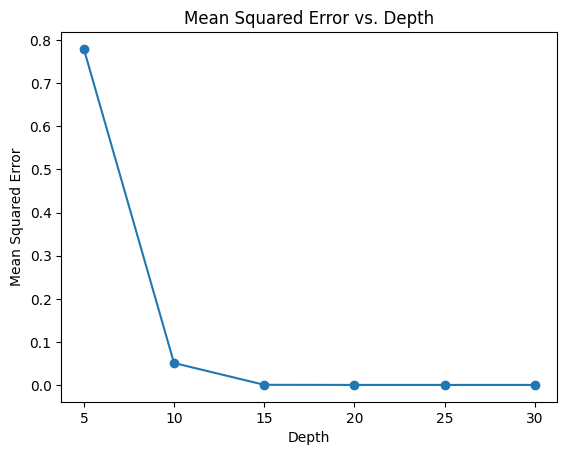

In [70]:
# Plotting the MSE scores
plt.plot(depths, mse_scores, marker='o')
plt.xlabel('Depth')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs. Depth')
plt.show()

### Training with Random Forest
This model will allow us predict an X, Y, Z coordinate in relation to the independent features supplied

In [71]:
model_randomForest = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)  # for regression

model_randomForest.fit(X_train_RF, Y_train_RF)
y_pred = model_randomForest.predict(X_test_RF)

mse = mean_squared_error(Y_test_RF, y_pred)
print("Mean Squared Error:", mse)
rmse = math.sqrt(mse)
print("Root Squared Error:", rmse)

Mean Squared Error: 0.0006089915590061707
Root Squared Error: 0.024677754334747937


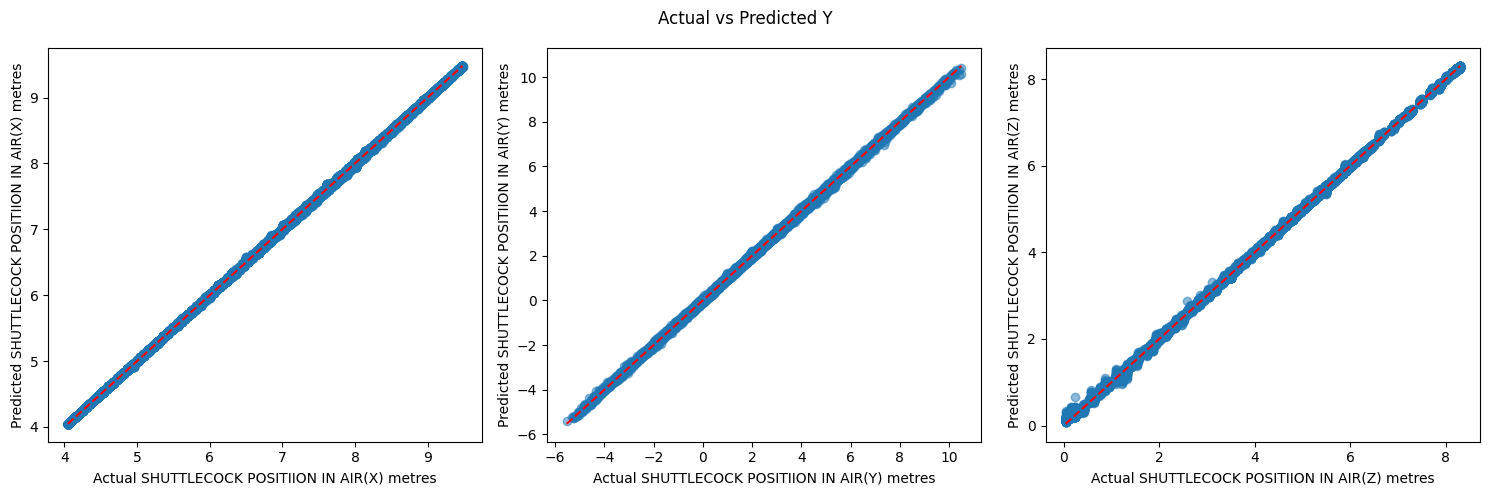

In [72]:
# Plotting the scatterplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plotting for each target variable
for i, target in enumerate(Y_features_RF.columns):
    ax[i].scatter(Y_test_RF[target], y_pred[:, i], alpha=0.5)
    ax[i].plot([Y_test_RF[target].min(), Y_test_RF[target].max()], [Y_test_RF[target].min(), Y_test_RF[target].max()], 'r--')
    ax[i].set_xlabel('Actual ' + target)
    ax[i].set_ylabel('Predicted ' + target)

plt.suptitle('Actual vs Predicted Y')
plt.tight_layout()
plt.show()

## Stage: Actual Testing with First Coordinate
To actually test if all the models work, the first point of an observation group will be used for testing. Test will be randomized and based on observation group. Assuming that we will know the sequence order of the observation since they are ordered, OBSERVATION NUMBER will be used to identify the first observation

In [122]:
import random
# copied to avoid alterations to cleaned data
test_data = temp_data.copy()

# choose a random from the observation groups to test
unique_observation_grps = test_data['OBSERVATION GROUP NUMBER'].nunique()
selected_test_num = random.randint(1, unique_observation_grps)
print("Selected Observation Group Number is :", selected_test_num)

# alternatively can hardcode to replicate results
# selected_test_num = ?

# retrieve all the rows from the data related to randomly selected row
y_actual_coords = test_data[test_data['OBSERVATION GROUP NUMBER'] == selected_test_num]

# get the first coordinate of selected observation for input
y_first_coord = y_actual_coords.head(1)
y_first_coord = y_first_coord[['SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres', 'SHUTTLECOCK POSITIION IN AIR(Z) metres', 'OBSERVATION NUMBER']]

# show the test data
y_first_coord


Selected Observation Group Number is : 485


,SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER
54518,4.077079,1.953686,2.662796,1.0


### Generate Features for Input
Generate human initial position

In [123]:
# Generate Initial Human Position
rounded_value_x = math.floor(y_first_coord['SHUTTLECOCK POSITIION IN AIR(X) metres'])
rounded_value_y = round(y_first_coord['SHUTTLECOCK POSITIION IN AIR(Y) metres'])
rounded_value_z = y_first_coord['SHUTTLECOCK POSITIION IN AIR(Z) metres'].apply(lambda x: min(1.6, 2.6, key=lambda y: abs(y - x)))
# rounded_value_z = min(1.6, 2.6, key=lambda x: abs(x - y_first_coord['SHUTTLECOCK POSITIION IN AIR(Z) metres']))

y_first_coord['HUMAN PLAYER POSITION (X) metres'] = rounded_value_x
y_first_coord['HUMAN PLAYER POSITION (Y) metres'] = rounded_value_y
y_first_coord['HUMAN PLAYER POSITION (Z) metres'] = rounded_value_z

y_first_coord

C:\Users\Matthew Chuang\AppData\Local\Temp\ipykernel_10792\3174915428.py:2: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



,SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,HUMAN PLAYER POSITION (Z) metres
54518,4.077079,1.953686,2.662796,1.0,4,2.0,2.6


Generate initial velocity, slant angle, firing angle

In [124]:
# calculate displacement
X_displacement_test = y_first_coord['SHUTTLECOCK POSITIION IN AIR(X) metres'] - y_first_coord['HUMAN PLAYER POSITION (X) metres']
Y_displacement_test = y_first_coord['SHUTTLECOCK POSITIION IN AIR(Y) metres'] - y_first_coord['HUMAN PLAYER POSITION (Y) metres'] 
Z_displacement_test = y_first_coord['SHUTTLECOCK POSITIION IN AIR(Z) metres'] - y_first_coord['HUMAN PLAYER POSITION (Z) metres']

# calculate initial firing angle
firing_angle_radians = math.atan(X_displacement_test / Z_displacement_test)
firing_angle_degrees = math.degrees(firing_angle_radians)
# round to nearest 10 for firing angle
y_first_coord['INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)'] = round(firing_angle_degrees / 10) * 10

# calculate initial slant angle
slant_angle_radians = math.atan(Y_displacement_test / X_displacement_test)
slant_angle_degrees = math.degrees(slant_angle_radians)
y_first_coord['INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'] = round(slant_angle_degrees)

# Calculate the initial velocity (v₀)
time_elapsed = 0.1
displacement = math.sqrt(X_displacement_test**2 + Y_displacement_test**2 + Z_displacement_test**2)
initial_velocity = round(displacement/time_elapsed)
# round to nearest 10 for velocity
y_first_coord['INITITAL VELOCITY OF SHUTTELCOCK(m/s)'] = initial_velocity
y_first_coord

C:\Users\Matthew Chuang\AppData\Local\Temp\ipykernel_10792\3704619852.py:7: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Matthew Chuang\AppData\Local\Temp\ipykernel_10792\3704619852.py:13: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\Matthew Chuang\AppData\Local\Temp\ipykernel_10792\3704619852.py:19: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



,SHUTTLECOCK POSITIION IN AIR(X) metres,SHUTTLECOCK POSITIION IN AIR(Y) metres,SHUTTLECOCK POSITIION IN AIR(Z) metres,OBSERVATION NUMBER,HUMAN PLAYER POSITION (X) metres,HUMAN PLAYER POSITION (Y) metres,HUMAN PLAYER POSITION (Z) metres,INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE),INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE),INITITAL VELOCITY OF SHUTTELCOCK(m/s)
54518,4.077079,1.953686,2.662796,1.0,4,2.0,2.6,50,-31,1


Predict number of observations within a Trajectory for test record

In [125]:
# select the input features we want to feed into the decision tree model to prediction observation
X_actual_test_DT = y_first_coord[['HUMAN PLAYER POSITION (X) metres', 
                                    'HUMAN PLAYER POSITION (Y) metres',
                                    'HUMAN PLAYER POSITION (Z) metres', 
                                    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                                    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                                    'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]

predicted_observation = int(model_decisionTree.predict(X_actual_test_DT))
print("Predicted observation is :", predicted_observation)
print("Actual number of observations is :", len(y_actual_coords))

Predicted observation is : 128
Actual number of observations is : 128


Predict the entire trajectory based on the test coordinate given

In [126]:
# container to store prepared input features we want to feed into the random forest regression model to predict entire trajectory x, y, z coordinates
X_actual_test_RF = []
# select x features and change the observation number accordingly and add into container
for obs_num in range(1, predicted_observation+1):
    temp = (y_first_coord[['HUMAN PLAYER POSITION (X) metres', 
                            'HUMAN PLAYER POSITION (Y) metres',
                            'HUMAN PLAYER POSITION (Z) metres',
                            'INITITAL VELOCITY OF SHUTTELCOCK(m/s)', 
                            'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)', 
                            'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)']]).values.tolist()
    temp_obs_row = temp[:5][0]
    temp_obs_row.append(obs_num)
    X_actual_test_RF.append(temp_obs_row)

X_actual_test_RF

[[4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 1],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 2],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 3],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 4],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 5],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 6],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 7],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 8],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 9],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 10],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 11],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 12],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 13],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 14],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 15],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 16],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 17],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 18],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 19],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 20],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 21],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 22],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 23],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 24],
 [4.0, 2.0, 2.6, 1.0, 50.0, -31.0, 25],
 [4.0, 2.

In [127]:
# Turn it into dataframe
column_names = [
    'HUMAN PLAYER POSITION (X) metres',
    'HUMAN PLAYER POSITION (Y) metres',
    'HUMAN PLAYER POSITION (Z) metres',
    'INITITAL VELOCITY OF SHUTTELCOCK(m/s)',
    'INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)',
    'INITIAL SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)',
    'OBSERVATION NUMBER'
]

X_actual_test_RF_DF = pd.DataFrame(X_actual_test_RF, columns = column_names)
predicted_trajectory_points = model_randomForest.predict(X_actual_test_RF_DF)

### Overall Evaluation

In [134]:
# Do an error evaluation
y_actual_test_df = y_actual_coords[['SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres', 'SHUTTLECOCK POSITIION IN AIR(Z) metres']]

mse = mean_squared_error(y_actual_test_df, predicted_trajectory_points)
rmse = math.sqrt(mse)
print("Mean Square Error of the test is :", mse)
print("Root Mean Square Error of the test is :", rmse)

Mean Square Error of the test is : 8.588879915011962e-05
Root Mean Square Error of the test is : 0.009267621008118513


In [140]:
import plotly.graph_objects as go
import plotly.offline as offline
y_actual_test_df

columns_n = ['X','Y','Z']
predicted_trajectory_points_df = pd.DataFrame(predicted_trajectory_points, columns=columns_n)

# Extract X, Y, Z coordinates from y_actual_test and predicted_trajectory_point
x_actual = y_actual_test_df['SHUTTLECOCK POSITIION IN AIR(X) metres']
y_actual = y_actual_test_df['SHUTTLECOCK POSITIION IN AIR(Y) metres']
z_actual = y_actual_test_df['SHUTTLECOCK POSITIION IN AIR(Z) metres']
z_actual

x_predicted = predicted_trajectory_points_df['X'].values
y_predicted = predicted_trajectory_points_df['Y'].values
z_predicted = predicted_trajectory_points_df['Z'].values

# Create a scatter plot for actual trajectory
actual_trace = go.Scatter3d(x=x_actual, y=y_actual, z=z_actual, mode='markers', marker=dict(color='blue'), name='Actual Trajectory')

# Create a scatter plot for predicted trajectory
predicted_trace = go.Scatter3d(x=x_predicted, y=y_predicted, z=z_predicted, mode='markers', marker=dict(color='red'), name='Predicted Trajectory')

# Set the data trace
data = [actual_trace, predicted_trace]

# Set layout and title
layout = go.Layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        xaxis=dict(range=[-15, 15]),  # Set X-axis range
        yaxis=dict(range=[-15, 15]),  # Set Y-axis range
        zaxis=dict(range=[0, 15])   # Set Z-axis range
    ),
    title='Actual vs Predicted Trajectory'
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Save the plot as an HTML file
offline.plot(fig, filename='overall_trajectory_evaluation.html')

'overall_trajectory_evaluation.html'